In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
from scipy import special
import keras
from keras.models import Model
from keras.layers import Dense, Input

In [12]:
def latest_version(cat):#this function gets the latest version of our catalog
    """
    input
    cat: esmdatastore
    output
    esmdatastore with latest DRS versions
    """
    latest_cat = cat.df.sort_values(by=['version','path']).drop_duplicates(['temporal subset','model','mip_table',
                                               'institute','variable','ensemble_member',
                                               'grid_label','experiment_id'],keep='last')
    return latest_cat


In [8]:
col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col = intake.open_esm_datastore(col_url)
esmcol_data = col.esmcol_data

In [9]:
model_name = 'GFDL-ESM4'

In [10]:
#mlotst, tos,uo,vo

In [11]:
#tos_ sea surface temperature
#area cello
#ofx ocean fixed
#omon  ocean monthly average 

In [13]:

query_Omon_tos = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 mip_table=['Omon'],
                 ensemble_member=["r1i1p1f1","r1i1p1f2"],
                 model= model_name,
                 grid_label=['gn'],
                 variable=["tos"])
query_Ofx = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 mip_table=['Ofx'],
                 #ensemble_member=["r1i1p1f1","r1i1p1f2"],
                 model= model_name,
                 grid_label=['gn'],
                 variable=["areacello"])

In [14]:
cat_Omon_tos = col.search(**query_Omon_tos)
cat_Omon_tos_lat = latest_version(cat_Omon_tos)

cat_Omon_tos_latest = intake.open_esm_datastore(cat_Omon_tos_lat,esmcol_data=esmcol_data)

In [15]:
cat_Ofx = col.search(**query_Ofx)
cat_Ofx_lat = latest_version(cat_Ofx)

cat_Ofx_latest = intake.open_esm_datastore(cat_Ofx_lat,esmcol_data=esmcol_data)

In [16]:
dict_Omon_tos = cat_Omon_tos_latest.to_dataset_dict(storage_options=dict(anon=True),cdf_kwargs={'decode_times': True,'chunks': {'time': 1}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [17]:
dict_Ofx = cat_Ofx_latest.to_dataset_dict(storage_options=dict(anon=True),cdf_kwargs={'decode_times': True,'chunks': {}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [18]:
dict_Omon_tos.keys()

dict_keys(['CMIP6.NOAA-GFDL.GFDL-ESM4.abrupt-4xCO2.Omon', 'CMIP6.NOAA-GFDL.GFDL-ESM4.1pctCO2.Omon', 'CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Omon'])

In [19]:
ds_Ofx = dict_Ofx["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Ofx"] #xarray dataset object to access Ofx areacello dataset used to calculate the weighted average

CALCULATING the summation of areacello

In [20]:
#TODO INSERT CELL SELECT region of interest in areacello
areacello_nino3 = ds_Ofx.areacello.sel(y = slice(-5,5), x = slice(-150,-90))

In [21]:
#TODO 
#CALCULATE total_areacello, summation across lat,lon (in our dataset y,x respectively)

total_areacello = areacello_nino3.sum(dim=('x', 'y'))


NINO3 INDEX CALCULATION 

REGION 

(5S-5N , 150W-90W) 

SELECT tos and areacello for the region of interest

## Historical

In [22]:
ds_hist = dict_Omon_tos["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Omon"]


In [26]:
ds_hist.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
2014-08-16 12:00:00,2014-08-16 12:00:00
2014-09-16 00:00:00,2014-09-16 00:00:00
2014-10-16 12:00:00,2014-10-16 12:00:00


In [32]:
tos_his = ds_hist.tos.sel(time = slice("1980", "2011"))

In [33]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 
#tos = ds.tos......
tos_his = ds_hist.tos.sel(y = slice(-5,5), x = slice(-150,-90))
#tos

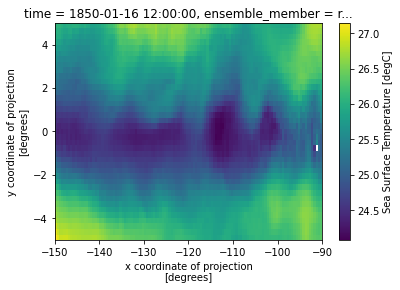

In [34]:
tos_his.isel(time=0).plot()

CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [35]:
tos_mean_nino3_his = (tos_his * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [36]:
tos_mean_nino3_his.compute()

<xarray.DataArray (ensemble_member: 1, time: 1980)>
array([[25.484543, 25.101374, 25.64276 , ..., 23.6965  , 23.806202,
        24.474295]], dtype=float32)
Coordinates:
  * time             (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [37]:
tos_mean_nino3_his.size #1980 values, 1 value per month , 12 per year for 165 years

1980

In [38]:
tos_mean_nino3_his.isel(time=0).compute()

<xarray.DataArray (ensemble_member: 1)>
array([25.484543], dtype=float32)
Coordinates:
    time             object 1850-01-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [39]:
datetimeindex = tos_mean_nino3_his.indexes['time'].to_datetimeindex()
tos_mean_nino3_his['time'] = datetimeindex


<ipython-input-39-e7b25880c2d7>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = tos_mean_nino3_his.indexes['time'].to_datetimeindex()


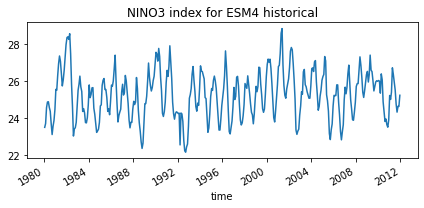

In [40]:
tos_mean_nino3_his.sel(time=slice('1980','2011')).plot(aspect=2, size=3)
plt.title("NINO3 index for ESM4 historical")
plt.tight_layout()
plt.draw()

ADDITIONAL EXPLORATION

CLIMATOLOGY (average all Jans, Febs, etc) CALC EXAMPLES (YEARS NEED A TWEAK, calculate for 20 year chunks or as needed)

In [43]:
tos_nino3_climatology = tos_his.sel(time=slice('1980','2011')).groupby('time.month').mean(dim='time')


In [44]:
tos_nino3_climatology.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (ensemble_member: 1, month: 12, y: 39, x: 120)>
array([[[[27.511238, 27.480799, 27.463413, ..., 27.347897, 27.351097,
          27.354565],
         [27.429424, 27.396082, 27.376625, ..., 27.365078, 27.366772,
          27.366291],
         [27.335476, 27.30389 , 27.291784, ..., 27.357105, 27.359276,
          27.366688],
         ...,
         [26.769493, 26.761211, 26.770145, ..., 27.072662, 27.142595,
          27.197163],
         [26.844059, 26.822792, 26.825037, ..., 27.090508, 27.177284,
          27.245272],
         [26.913523, 26.894135, 26.897577, ..., 27.096073, 27.199215,
          27.281734]],

        [[27.872047, 27.853748, 27.848259, ..., 27.92874 , 27.897543,
          27.877398],
         [27.729877, 27.719173, 27.708008, ..., 27.894463, 27.855282,
          27.832958],
         [27.565212, 27.563206, 27.566444, ..., 27.808167, 27.755795,
          27.735897],
...
         [27.098568, 27.07713 , 27.056187, ..., 27.435528, 27.428585,
          27.410013],
         [27.215738, 27.1745  , 27.156555, ..., 27.475876, 27.475712,
          27.456068],
         [27.328804, 27.296644, 27.27203 , ..., 27.508045, 27.507118,
          27.487663]],

        [[27.190006, 27.148232, 27.100464, ..., 25.15946 , 25.15474 ,
          25.148602],
         [27.125383, 27.078712, 27.033192, ..., 25.127712, 25.127565,
          25.120028],
         [27.063356, 27.010632, 26.966145, ..., 25.088284, 25.08856 ,
          25.083004],
         ...,
         [26.91344 , 26.88616 , 26.877892, ..., 27.401964, 27.442736,
          27.491543],
         [27.03382 , 27.010565, 26.994549, ..., 27.401398, 27.449806,
          27.51314 ],
         [27.131283, 27.127209, 27.108566, ..., 27.384546, 27.43932 ,
          27.51024 ]]]], dtype=float32)
Coordinates:
    lat              (y, x) float32 -4.872 -4.872 -4.872 ... 4.872 4.872 4.872
    lon              (y, x) float32 -149.8 -149.2 -148.8 ... -90.75 -90.25
  * x                (x) float64 -149.8 -149.2 -148.8 ... -91.25 -90.75 -90.25
  * y                (y) float64 -4.872 -4.615 -4.359 ... 4.359 4.615 4.872
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

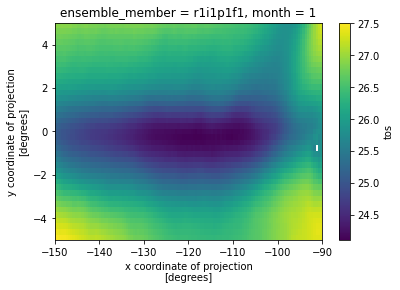

In [45]:
tos_nino3_climatology.isel(month=0).plot()

monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [47]:
tos_sel = tos_his.sel(time=slice('1980','2011'))
index_nino3 = (tos_sel.groupby('time.month')-tos_nino3_climatology).mean(dim=['x','y'])

In [48]:
index_nino3.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (ensemble_member: 1, time: 384)>
array([[-2.29843068e+00, -2.05903292e+00, -1.39014637e+00,
        -1.76391602e+00, -1.57506311e+00, -1.05423379e+00,
        -5.95366895e-01, -5.09500325e-01, -8.56141925e-01,
        -6.13373399e-01, -5.86020350e-01, -6.93869650e-01,
        -2.40143120e-01, -2.52339512e-01,  3.16560894e-01,
         3.12041938e-01,  9.06876862e-01,  1.44978213e+00,
         1.44752502e+00,  1.54385448e+00,  2.11154985e+00,
         2.41297483e+00,  2.79833150e+00,  2.82683349e+00,
         2.56894088e+00,  2.64403296e+00,  2.30948901e+00,
         1.94038081e+00,  1.02473378e+00,  1.92848638e-01,
        -3.49284112e-01, -1.17232752e+00, -5.47670722e-01,
        -6.95429802e-01, -6.84865057e-01, -4.62527663e-01,
        -2.83263862e-01,  6.73374757e-02,  3.16339314e-01,
        -9.37379777e-01, -1.01779890e+00, -1.26832008e+00,
        -4.52542633e-01,  8.57189521e-02, -2.06922129e-01,
        -4.32806641e-01, -4.29273516e-01, -4.36750770e-01,
         2.06160941e-03, -6.56363308e-01, -6.83060050e-01,
        -9.98162687e-01, -8.08514357e-01, -1.08665311e+00,
        -7.55323291e-01, -4.78964359e-01, -7.39538312e-01,
        -8.70950758e-01, -1.05180252e+00, -1.37401927e+00,
...
        -1.19540364e-01, -4.46359038e-01, -2.90874064e-01,
        -2.39235952e-01,  4.10874546e-01,  3.09122801e-01,
         2.77361218e-02,  2.89188862e-01, -5.18847816e-02,
        -2.92367399e-01, -1.23000473e-01, -2.96488583e-01,
        -8.13030526e-02,  1.00377098e-01, -8.73775855e-02,
        -2.38389708e-02,  8.59047830e-01,  1.23324609e+00,
         1.25884771e+00,  1.20604002e+00,  1.15615940e+00,
         1.31992078e+00,  1.47736192e+00,  1.21241271e+00,
         7.33900666e-01,  1.92136034e-01,  3.98111165e-01,
         7.79745162e-01,  1.39675289e-01,  8.88140500e-01,
         1.07161009e+00,  1.27261996e+00,  1.73896205e+00,
         1.78648663e+00,  1.57210100e+00,  8.48011434e-01,
         2.41576135e-01,  2.39540979e-01, -6.05479300e-01,
        -2.37951487e-01, -3.85004103e-01, -7.53098667e-01,
        -6.05716825e-01, -3.82915080e-01, -1.34487487e-02,
        -5.30491233e-01, -9.46623921e-01, -1.24571538e+00,
        -5.71187377e-01, -7.52207935e-01, -5.51589370e-01,
         9.07281637e-02, -8.82925019e-02,  3.00632894e-01,
         5.59765697e-01,  5.67717493e-01,  3.59050363e-01,
         4.64432389e-01,  1.81016430e-01,  8.95821452e-02]], dtype=float32)
Coordinates:
  * time             (time) object 1980-01-16 12:00:00 ... 2011-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
    month            (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12

<ipython-input-49-90fd70a17ab6>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = index_nino3.indexes['time'].to_datetimeindex()


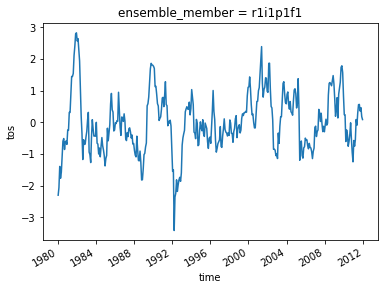

In [49]:
datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
index_nino3['time'] = datetimeindex
index_nino3.plot()

## 1%CO2

In [23]:
ds_1pct = dict_Omon_tos["CMIP6.NOAA-GFDL.GFDL-ESM4.1pctCO2.Omon"]

In [25]:
ds_1pct.time.to_dataframe()

,time
time,
0001-01-16 12:00:00,0001-01-16 12:00:00
0001-02-15 00:00:00,0001-02-15 00:00:00
0001-03-16 12:00:00,0001-03-16 12:00:00
0001-04-16 00:00:00,0001-04-16 00:00:00
0001-05-16 12:00:00,0001-05-16 12:00:00
...,...
0150-08-16 12:00:00,0150-08-16 12:00:00
0150-09-16 00:00:00,0150-09-16 00:00:00
0150-10-16 12:00:00,0150-10-16 12:00:00


In [29]:
ds_1pct.info


<bound method Dataset.info of <xarray.Dataset>
Dimensions:          (bnds: 2, ensemble_member: 1, time: 1800, vertex: 4, x: 720, y: 576)
Coordinates:
    lat              (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon              (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
  * bnds             (bnds) float64 1.0 2.0
  * time             (time) object 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
  * x                (x) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * y                (y) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
Dimensions without coordinates: vertex
Data variables:
    lat_bnds         (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
    lon_bnds         (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
    time_bnds        (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    tos      

In [27]:
tos_1pct = ds_1pct.tos.sel(time = slice("1980", "2011"))

In [36]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 
#tos = ds.tos......
tos_1pct = ds_1pct.tos.sel(y = slice(-5,5), x = slice(-150,-90))
#tos

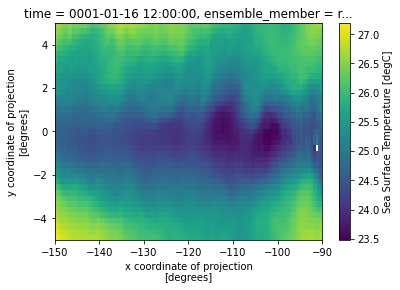

In [37]:
tos_1pct.isel(time=0).plot()

CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [38]:
tos_mean_nino3_1pct = (tos_1pct * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [39]:
tos_mean_nino3_1pct.compute()

<xarray.DataArray (ensemble_member: 1, time: 1800)>
array([[25.240553, 25.748297, 26.135637, ..., 27.92831 , 28.12126 ,
        28.985657]], dtype=float32)
Coordinates:
  * time             (time) object 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [40]:
tos_mean_nino3_1pct.size #1980 values, 1 value per month , 12 per year for 165 years

1800

In [41]:
tos_mean_nino3_1pct.isel(time=0).compute()

<xarray.DataArray (ensemble_member: 1)>
array([25.240553], dtype=float32)
Coordinates:
    time             object 0001-01-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [42]:
datetimeindex_1pct = tos_mean_nino3_1pct.indexes['time'].to_datetimeindex()
tos_mean_nino3_1pct['time'] = datetimeindex_1pct


ValueError: Cannot convert date 0001-01-16 12:00:00 to a date in the standard calendar.  Reason: Out of bounds nanosecond timestamp: 1-01-16 12:00:00.

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

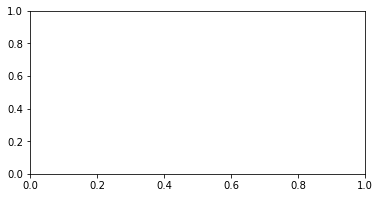

In [44]:
tos_mean_nino3_1pct.sel(time=slice('1980','2011')).plot(aspect=2, size=3)
plt.title("NINO3 index for ESM4 1%CO2")
plt.tight_layout()
plt.draw()

## Abrupt-4xCO2

In [43]:
ds_4x = dict_Omon_tos["CMIP6.NOAA-GFDL.GFDL-ESM4.abrupt-4xCO2.Omon"]

In [35]:
tos_4x = ds_4x.tos.sel(time = slice("1980", "2011"))

In [36]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 
#tos = ds.tos......
tos_1pct = ds_1pct.tos.sel(y = slice(-5,5), x = slice(-150,-90))
#tos

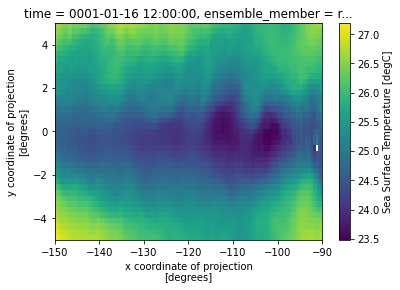

In [37]:
tos_1pct.isel(time=0).plot()

CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [38]:
tos_mean_nino3_1pct = (tos_1pct * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [ ]:
tos_mean_nino3_1pct.compute()

In [ ]:
tos_mean_nino3_1pct.size #1980 values, 1 value per month , 12 per year for 165 years

In [ ]:
tos_mean_nino3_1pct.isel(time=0).compute()

In [ ]:
datetimeindex_1pct = tos_mean_nino3_1pct.indexes['time'].to_datetimeindex()
tos_mean_nino3_1pct['time'] = datetimeindex_1pct


In [ ]:
tos_mean_nino3_1pct.sel(time=slice('1980','2011')).plot(aspect=2, size=3)
plt.title("NINO3 index for ESM4 1%CO2")
plt.tight_layout()
plt.draw()